## Mask R-CNN - Train on NewShapes V2 Dataset

### Notes from implementation

This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys, math, io, time, gc, argparse, platform, pprint, pickle
import numpy as np
import tensorflow as tf
import keras
import keras.backend as KB
sys.path.append('../')

import mrcnn.utils        as utils
import mrcnn.visualize    as visualize
import mrcnn.prep_notebook as prep

from datetime            import datetime   
from mrcnn.utils         import command_line_parser, Paths
from mrcnn.datagen       import data_generator, load_image_gt, data_gen_simulate
from mrcnn.newshapes     import prep_newshape_dataset

pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4,threshold=1000, suppress = True)
start_time = datetime.now().strftime("%m-%d-%Y @ %H:%M:%S")
print()
print('--> Execution started at:', start_time)
print("    Tensorflow Version: {}   Keras Version : {} ".format(tf.__version__,keras.__version__))

##------------------------------------------------------------------------------------
## Parse command line arguments
##------------------------------------------------------------------------------------
parser = command_line_parser()
input_parms = " --epochs           2 "
input_parms +=" --steps_in_epoch   100 "
input_parms +=" --last_epoch       222" 
input_parms +=" --batch_size       1 " 
input_parms +=" --lr               0.0001 "
input_parms +=" --val_steps        8 " 
input_parms +=" --mrcnn_logs_dir   train_mrcnn_newshapes2 "
input_parms +=" --mrcnn_model      init "
input_parms +=" --mrcnn_layers     res3+"
input_parms +=" --scale_factor     1 "
input_parms +=" --opt              adam "
input_parms +=" --sysout           screen "
input_parms +=" --toy_dataset      newshapes2"
input_parms +=" --new_log_folder    "
# input_parms +=" --fcn_logs_dir   train_fcn8_newshapes "
# input_parms +=" --fcn_model      init "
# input_parms +=" --fcn_arch       fcn8 " 
# input_parms +=" --fcn_layers     all " 
# input_parms +="--fcn_model /home/kbardool/models/train_fcn_adagrad/shapes20180709T1732/fcn_shapes_1167.h5"
 
args = parser.parse_args(input_parms.split())
utils.display_input_parms(args)

D:\Program Files\Anaconda3\envs\TFG\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


 Init Image Class - Possible Object Choices:  {'tree': 5, 'cloud': 3, 'person': 5, 'car': 3, 'building': 3, 'sun': 1, 'truck': 3, 'airplane': 3}
 Init Image Class - Custom Color Keys      :  ['tree', 'cloud', 'person', 'ground', 'sun', 'sky']
 Init Image Class - Object Priority List   :  ['building', 'tree', 'car']
 Init Image Class - BUILD_MAX_TRIES        :  7
 Init Image Class - person_car_gap         :  10

--> Execution started at: 03-16-2019 @ 14:54:35
    Tensorflow Version: 1.10.0   Keras Version : 2.2.2 

   Arguments passed :
   --------------------
   batch_size                     1
   coco_classes                   None
   epochs                         2
   evaluate_method                1
   fcn_arch                       FCN32
   fcn_bce_loss_class             0
   fcn_bce_loss_method            1
   fcn_layers                     ['fcn32+']
   fcn_logs_dir                   train_fcn
   fcn_losses                     fcn_BCE_loss
   fcn_model                      last


###  Build Model

In [2]:
mrcnn_model= prep.build_mrcnn_training_pipeline_newshapes(args = args, verbose = True)


--> Execution started at: 03-16-2019 @ 14:54:45
    Tensorflow Version: 1.10.0   Keras Version : 2.2.2 
    Build_mrcnn_inference_pipeline_newshapes MODE is : training shapes:  newshapes2

   Arguments passed :
   --------------------
   batch_size                     1
   coco_classes                   None
   epochs                         2
   evaluate_method                1
   fcn_arch                       FCN32
   fcn_bce_loss_class             0
   fcn_bce_loss_method            1
   fcn_layers                     ['fcn32+']
   fcn_logs_dir                   train_fcn
   fcn_losses                     fcn_BCE_loss
   fcn_model                      last
   last_epoch                     222
   lr                             0.0001
   mrcnn_exclude_layers           None
   mrcnn_layers                   ['res3+']
   mrcnn_logs_dir                 train_mrcnn_newshapes2
   mrcnn_model                    init
   new_log_folder                 True
   opt                           


    Detection Target Layer : return  <class 'list'> 4
     output 0  shape (1, ?, 4)  type <class 'tensorflow.python.framework.ops.Tensor'> 
     output 1  shape (1, ?)  type <class 'tensorflow.python.framework.ops.Tensor'> 
     output 2  shape (1, ?, 4)  type <class 'tensorflow.python.framework.ops.Tensor'> 
     output 3  shape (1, ?, 4)  type <class 'tensorflow.python.framework.ops.Tensor'> 

>>> FPN Classifier Graph verbose: True
    INPUT: rois shape              :  shape: (1, ?, 4)             KB.shape:(None, 32, 4)         Keras Tensor: True
    INPUT: mrcnn feature_maps      :  value: 4
    -      feature_map P2          :  shape: (?, 32, 32, 256)      KB.shape:(None, 32, 32, 256)   Keras Tensor: True
    -      feature_map P3          :  shape: (?, 16, 16, 256)      KB.shape:(None, 16, 16, 256)   Keras Tensor: True
    -      feature_map P4          :  shape: (?, 8, 8, 256)        KB.shape:(None, 8, 8, 256)     Keras Tensor: True
    -      feature_map P5          :  shape: 

    alt_scores_2    :              :  shape: (?, 3)                KB.shape:(None, 3)             Keras Tensor: False
    alt_scores_2(scattered)        :  shape: (1, 9, 32, 3)         KB.shape:(1, 9, 32, 3)         Keras Tensor: False
    alt_scores_2_norm(by_class)    :  shape: (1, 9, 32, 3)         KB.shape:(1, 9, 32, 3)         Keras Tensor: False
    reshaped heatmap               :  shape: (1, 128, 128, 9)      KB.shape:(1, 128, 128, 9)      Keras Tensor: False
    gauss_scores    :              :  shape: (1, 9, 32, 24)        KB.shape:(1, 9, 32, 24)        Keras Tensor: False
    complete                       
                                   
    pred_refined_heatmap           :  shape: (1, 128, 128, 9)      KB.shape:(1, 128, 128, 9)      Keras Tensor: False
    pred_refnined_heatmap_scores   :  shape: (1, 9, 32, 24)        KB.shape:(1, 9, 32, 24)        Keras Tensor: False
    complete                       
    > CHMLayer compute_output_shape()
input:  0       <class 'tupl

    loss      : <unknown> Tensor("mrcnn_bbox_loss/Shape:0", shape=(?,), dtype=int32) KerasTensor:  False
    mean loss : () Tensor("mrcnn_bbox_loss/Shape_1:0", shape=(0,), dtype=int32) KerasTensor:  False
    reshaped mean loss : (1, 1) Tensor("mrcnn_bbox_loss/Shape_2:0", shape=(2,), dtype=int32) KerasTensor:  False

>>> mrcnn_bbox_loss_graph 
    target_class_ids  size : (?, 32)
    pred_bbox size         : (?, 32, 9, 4)
    target_bbox size       : (?, 32, 4)
    reshpaed pred_bbox size         : (?, 9, 4)
    reshaped target_bbox size       : (?, 4)
    pred_bbox size         : (?, 4)
    target_bbox size       : (?, 4)
    loss      : <unknown> Tensor("mrcnn_bbox_loss/Shape_3:0", shape=(?,), dtype=int32) KerasTensor:  False
    mean loss : () Tensor("mrcnn_bbox_loss/Shape_4:0", shape=(0,), dtype=int32) KerasTensor:  False
    reshaped mean loss : (1, 1) Tensor("mrcnn_bbox_loss/Shape_5:0", shape=(2,), dtype=int32) KerasTensor:  False
 self.keras_model.losses :  0
[]

>>> Build MaskR

###  Print some model information 

In [ ]:
mrcnn_model.display_layer_info()

In [ ]:
# t1 = mrcnn_model.get_trainable_layers()
# for i, tt in enumerate(t1):
#     print(i, tt.name)

### Load saved weights

In [ ]:
##------------------------------------------------------------------------------------
## Load Mask RCNN Model Weight file
##------------------------------------------------------------------------------------
## WHEN RUNNING TRAINING AND INITIALIZING WEIGHTS FROM From mask_rcnn_shapes.h5
## MUST EXCLUDE "mrcnn_class_logits" and "mrcnn_bbox_fc" layers
exclude_list = ["mrcnn_class_logits", "mrcnn_bbox_fc"] 
mrcnn_model.load_model_weights(init_with = 'shapes', exclude = exclude_list, verbose = 1)   

## Not required after INIT epoch, as now weights have been initialized properly. 

# mrcnn_model.load_model_weights(init_with = 'last',verbose = 1)   

### Build newshape datasets

In [3]:
# del dataset_train, dataset_val, train_generator, val_generator
# from mrcnn.prep_notebook import prep_newshape_dataset
##------------------------------------------------------------------------------------
## Build & Load Training and Validation datasets
##------------------------------------------------------------------------------------
# dataset_train, train_generator = prep_newshape_dataset( mrcnn_model.config, 10000, generator=True)
# dataset_val  , val_generator   = prep_newshape_dataset( mrcnn_model.config,  2500, generator=True)
# with open('E:\\git_projs\\MRCNN3\\train_newshapes\\newshapes_training_dataset_10000_A.pkl', 'wb') as outfile:
#     pickle.dump(dataset_train, outfile)
# with open('E:\\git_projs\\MRCNN3\\train_newshapes\\newshapes_validation_dataset_2500_A.pkl', 'wb') as outfile:
#     pickle.dump(dataset_val, outfile)

## -- OR --
dataset_path = 'E:\\git_projs\\mrcnn3\\train_newshapes_2'
with open(os.path.join(dataset_path, 'newshapes2_training_dataset_15000_A.pkl'), 'rb') as outfile:
    dataset_train = pickle.load(outfile)
with open(os.path.join(dataset_path, 'newshapes2_validation_dataset_2500_A.pkl'), 'rb') as outfile:
    dataset_val = pickle.load(outfile)

In [4]:
print(type(dataset_train))
print(type(dataset_val))
# print(type(train_generator),type(val_generator))
print(len(dataset_train.image_info))
print(len(dataset_val.image_info))
print(len(dataset_train.image_ids), len(dataset_val.image_info))
# dataset_train.display_active_class_info()
print(dataset_train.class_from_source_map)
print(dataset_train.class_info)

<class 'mrcnn.newshapes2.NewImagesDataset'>
<class 'mrcnn.newshapes2.NewImagesDataset'>
15000
2500
15000 2500
{'newshapes2.7': 7, 'newshapes2.3': 3, 'newshapes2.4': 4, 'newshapes2.8': 8, 'newshapes2.1': 1, 'newshapes2.5': 5, 'newshapes2.2': 2, 'newshapes2.6': 6, '.0': 0}
[{'category': 'background', 'id': 0, 'source': '', 'img_count': 0, 'internal_id': 0, 'name': 'BG'}, {'category': None, 'id': 1, 'source': 'newshapes2', 'img_count': 0, 'internal_id': 1, 'name': 'person'}, {'category': None, 'id': 2, 'source': 'newshapes2', 'img_count': 0, 'internal_id': 2, 'name': 'car'}, {'category': None, 'id': 3, 'source': 'newshapes2', 'img_count': 0, 'internal_id': 3, 'name': 'sun'}, {'category': None, 'id': 4, 'source': 'newshapes2', 'img_count': 0, 'internal_id': 4, 'name': 'building'}, {'category': None, 'id': 5, 'source': 'newshapes2', 'img_count': 0, 'internal_id': 5, 'name': 'tree'}, {'category': None, 'id': 6, 'source': 'newshapes2', 'img_count': 0, 'internal_id': 6, 'name': 'cloud'}, {'cat

In [ ]:
## If we desire a generator, here it is:    
train_generator = data_generator(dataset_train, mrcnn_model.config, batch_size=mrcnn_model.config.BATCH_SIZE,
                                   shuffle = True, augment = False) 
val_generator = data_generator(dataset_val, mrcnn_model.config, batch_size=mrcnn_model.config.BATCH_SIZE,
                                   shuffle = True, augment = False) 
class_names = dataset_train.class_names
# dataset_train.display_active_classes()
print(mrcnn_model.config.BATCH_SIZE)
print(len(dataset_train.image_ids), len(dataset_val.image_ids))

###  Display some images from dataset

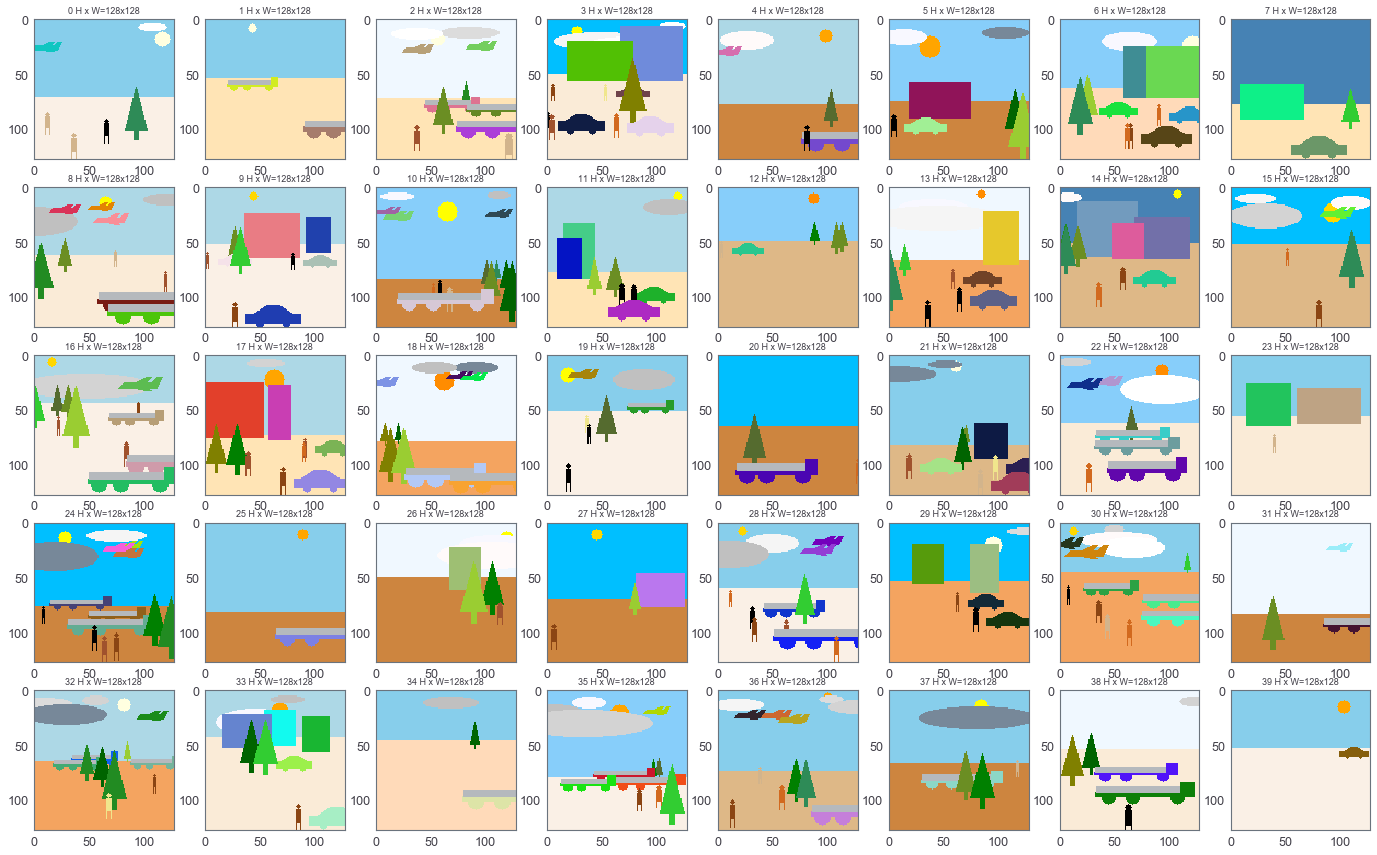

In [5]:
image_list = list(range(0,40))
image_titles = [str(i) for i in image_list]
images = prep.get_image_batch(dataset_train, image_list)
visualize.display_images(images, titles = image_titles, cols = 8, width = 24)

####  another method

In [ ]:
image_list = dataset_train.image_ids.tolist()[-40:] ## [-4:]
dataset_train.display_image(image_list, grid = False)

####  Display next image from generator

In [ ]:
train_batch_x, train_batch_y = next(train_generator)
visualize.display_training_batch(dataset_train, train_batch_x)

#### Load a specific image using image_id

In [ ]:
IMAGE_LIST = [2000,4000,5000,6000]
print(dataset_train.image_info[2000]['source'])
train_batch_x, train_batch_y = test_batch_x, test_batch_y = data_gen_simulate(dataset_train, mrcnn_model.config, IMAGE_LIST)
visualize.display_training_batch(dataset_train, train_batch_x)

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=6)

## Training mrcnn, fpn, rpn layers


Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

- Or now we can pass a list of layers we want to train in layers !
2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [6]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
# Wed 09-05-2018
# config.STEPS_PER_EPOCH        = 8
# config.EARLY_STOP_PATIENCE    = 70
# train_layers = [ 'mrcnn', 'fpn','rpn']   ## equivalent to "heads"
train_layers = ['all']
loss_names   = [ "rpn_class_loss", "rpn_bbox_loss" , "mrcnn_class_loss", "mrcnn_bbox_loss"]
# train_layers = [ 'mrcnn']
# loss_names   = [ "mrcnn_class_loss", "mrcnn_bbox_loss"]

mrcnn_model.config.LAST_EPOCH_RAN  =  0 #222
mrcnn_model.config.EPOCHS_TO_RUN   =  10 # 100
mrcnn_model.config.LEARNING_RATE   = 0.0001
# mrcnn_model.config.STEPS_PER_EPOCH = 2
# mrcnn_model.config.SYSOUT = 'screen'
 
print('    last epoch ran : ',mrcnn_model.config.LAST_EPOCH_RAN)
print('    epochs to run  : ',mrcnn_model.config.EPOCHS_TO_RUN)
print('    steps per epoch: ',mrcnn_model.config.STEPS_PER_EPOCH)
print('    learning rate  : ', mrcnn_model.config.LEARNING_RATE)
print('    momentum       : ', mrcnn_model.config.LEARNING_MOMENTUM)
print('    weight decay   : ',mrcnn_model.config.WEIGHT_DECAY)

    last epoch ran :  0
    epochs to run  :  10
    steps per epoch:  100
    learning rate  :  0.0001
    momentum       :  0.9
    weight decay   :  0.0001


In [7]:
mrcnn_model.epoch = mrcnn_model.config.LAST_EPOCH_RAN
mrcnn_model.train(dataset_train, 
            dataset_val, 
            learning_rate = mrcnn_model.config.LEARNING_RATE, 
            epochs_to_run = mrcnn_model.config.EPOCHS_TO_RUN,
            layers = train_layers,
            losses = loss_names)                  

['all']
['.*']
layers regex : .*
type train_dataset: <class 'mrcnn.newshapes2.NewImagesDataset'>
type val_dataset: <class 'mrcnn.newshapes2.NewImagesDataset'>
    learning rate :  0.0001
    momentum      :  0.9


Selecting layers to train
-------------------------
Layer    Layer Name               Layer Type
   0  input_image            (InputLayer          )   ............................no weights to train ]
   1  zero_padding2d_1       (ZeroPadding2D       )   ............................no weights to train ]
   2  conv1                  (Conv2D              )   TRAIN 
   3  bn_conv1               (BatchNorm           )   TRAIN 
   4  activation_1           (Activation          )   ............................no weights to train ]
   5  max_pooling2d_1        (MaxPooling2D        )   ............................no weights to train ]
   6  res2a_branch2a         (Conv2D              )   TRAIN 
   7  bn2a_branch2a          (BatchNorm           )   TRAIN 
   8  activation_2           


L2 Regularization losses:
-------------------------
   Tensor("truediv:0", shape=(), dtype=float32)    name: truediv:0
   Tensor("truediv_1:0", shape=(), dtype=float32)    name: truediv_1:0
   Tensor("truediv_2:0", shape=(), dtype=float32)    name: truediv_2:0
   Tensor("truediv_3:0", shape=(), dtype=float32)    name: truediv_3:0
   Tensor("truediv_4:0", shape=(), dtype=float32)    name: truediv_4:0
   Tensor("truediv_5:0", shape=(), dtype=float32)    name: truediv_5:0
   Tensor("truediv_6:0", shape=(), dtype=float32)    name: truediv_6:0
   Tensor("truediv_7:0", shape=(), dtype=float32)    name: truediv_7:0
   Tensor("truediv_8:0", shape=(), dtype=float32)    name: truediv_8:0
   Tensor("truediv_9:0", shape=(), dtype=float32)    name: truediv_9:0
   Tensor("truediv_10:0", shape=(), dtype=float32)    name: truediv_10:0
   Tensor("truediv_11:0", shape=(), dtype=float32)    name: truediv_11:0
   Tensor("truediv_12:0", shape=(), dtype=float32)    name: truediv_12:0
   Tensor("truediv_13:

      >> Add metric  rpn_bbox_loss  with metric tensor:  rpn_bbox_loss/rpn_bbox_loss:0  to list of metrics ...
    Loss name : mrcnn_class_loss  Related Layer is : mrcnn_class_loss
      >> Add metric  mrcnn_class_loss  with metric tensor:  mrcnn_class_loss/mrcnn_class_loss:0  to list of metrics ...
    Loss name : mrcnn_bbox_loss  Related Layer is : mrcnn_bbox_loss
      >> Add metric  mrcnn_bbox_loss  with metric tensor:  mrcnn_bbox_loss/mrcnn_bbox_loss:0  to list of metrics ...

 Final Keras metric_names:
 -------------------------
['loss', 'rpn_class_loss', 'rpn_bbox_loss', 'mrcnn_class_loss', 'mrcnn_bbox_loss']

Starting at epoch   0 of 10 epochs. LR=0.0001

Steps per epoch     100 
Batch size          1 
Checkpoint Path:    F:\models_newshapes2\train_mrcnn_newshapes2\mrcnn20190316T1454\mrcnn_{epoch:04d}.h5 
Learning Rate       0.0001 
Momentum            0.9 
Weight Decay:       0.0001 
VALIDATION_STEPS    8 
REDUCE_LR_FACTOR    0.5 
REDUCE_LR_COOLDOWN  30 
REDUCE_LR_PATIENCE  60

D:\Program Files\Anaconda3\envs\TFG\lib\site-packages\tensorflow\python\ops\gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
 12/100 [==>...........................] - ETA: 10:19 - loss: 35.5822 - rpn_class_loss: 2.6020 - rpn_bbox_loss: 9.1177 - mrcnn_class_loss: 16.5822 - mrcnn_bbox_loss: 7.2804

KeyboardInterrupt: 

In [ ]:
pp.pprint(mrcnn_model.keras_model._feed_inputs)
pp.pprint(mrcnn_model.keras_model._feed_targets)
pp.pprint(mrcnn_model.keras_model._feed_loss_fns)
pp.pprint(mrcnn_model.keras_model._feed_outputs)
pp.pprint(mrcnn_model.keras_model._feed_sample_weights)
pp.pprint(mrcnn_model.keras_model.updates)

## Fine Tuning
Fine tune all layers

    - #### Or now we can pass a list of layers we want to train in layers !
2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
# model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE / 10, epochs=211, layers="all")

train_layers = [ 'all']   ## equivalent to "heads"
loss_names   = [ "rpn_class_loss", "rpn_bbox_loss" , "mrcnn_class_loss", "mrcnn_bbox_loss"]

mrcnn_model.config.LAST_EPOCH_RAN = 122
mrcnn_model.config.EPOCHS_TO_RUN  = 100
mrcnn_model.config.LEARNING_RATE   = 0.001
# mrcnn_model.config.STEPS_PER_EPOCH = config.STEPS_PER_EPOCH

mrcnn_model.epoch = mrcnn_model.config.LAST_EPOCH_RAN
mrcnn_model.train(dataset_train, 
            dataset_val, 
            learning_rate = mrcnn_model.config.LEARNING_RATE / 10, 
            epochs_to_run = mrcnn_model.config.EPOCHS_TO_RUN,
            layers = train_layers,
            losses = loss_names)                  
#             epochs = 25,            # total number of epochs to run (accross multiple trainings)
#             batch_size = 0
#             steps_per_epoch = 0 


### Save 

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_2500.h5")
model.keras_model.save_weights(model_path)

## Push Data thru model using get_layer_output()

## Plot Heatmaps `pr_heatmap` and `gt_heatmap`

`pred_gaussian2` and `gt_gaussian2` from Tensorflow PCN layer

### Display ground truth bboxes from Shapes database (using `load_image_gt` )

Here we are displaying the ground truth bounding boxes as provided by the dataset

In [ ]:
img = 0
image_id = img_meta[img,0]
print('Image id: ',image_id)
p_original_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)
# print(p_gt_class_id.shape, p_gt_bbox.shape, p_gt_mask.shape)
print(p_gt_bbox[0:3,:])
print(p_gt_class_id)
visualize.draw_boxes(p_original_image, p_gt_bbox[0:3])

# image_id = img_meta[img,0]
# print('Image id: ',image_id)
# p_original_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
#             load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)
# # print(p_gt_class_id.shape, p_gt_bbox.shape, p_gt_mask.shape)
# print(p_gt_bbox)
# print(p_gt_class_id)
# visualize.draw_boxes(p_original_image, p_gt_bbox)

### Display Predicted  Ground Truth Bounding Boxes  `gt_tensor` and `gt_tensor2`

layers_out[22]  `gt_tensor` is based on input_gt_class_ids and input_normlzd_gt_boxes
layers_out[28]  `gt_tensor2` is based on input_gt_class_ids and input_normlzd_gt_boxes, generated using Tensorflow

Display the Ground Truth bounding boxes from the tensor we've constructed

In [ ]:
from mrcnn.utils  import stack_tensors, stack_tensors_3d
# print(gt_bboxes)
# visualize.display_instances(p_original_image, p_gt_bbox, p_gt_mask, p_gt_class_id, 
#                             dataset_train.class_names, figsize=(8, 8))
# pp.pprint(gt_bboxes)
img = 0
image_id = img_meta[img,0]

print('Image id: ',image_id)
p_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)   
gt_bboxes_stacked = stack_tensors_3d(layers_out[22][img])
print(gt_bboxes_stacked)
visualize.draw_boxes(p_image, gt_bboxes_stacked[0:2,2:6])


## Display RoI proposals `pred_bboxes` generated for one class

Display bounding boxes from tensor of proposals produced by the network 
Square: 1 , Circle:2 , Triangle 3

In [ ]:
img = 0
cls = 1 # <==== Class to display
pred_tensor = layers_out[19]   # numpy pred_tesnor
# pred_tensor = layers_out[25]   # tensorflow pred_tensor 

image_id = img_meta[img,0]
print('Image id: ',image_id)
p_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)
print(p_image_meta)dd
print(pred_tensor[img,cls,:].shape)
print(pred_tensor[img,cls])
#+'-'+str(np.around(int(x[1]),decimals = 3))
# class id: str(int(x[6]))+'-'+
caps = [str(int(x[0]))+'-'+str(np.around(x[1],decimals = 3))  for x in pred_tensor[img,cls,:].tolist() ]
print(caps)

visualize.draw_boxes(p_image, pred_tensor[img,cls,:,2:6], captions = caps)

In [ ]:
layers_out[0][0] * [128, 128,128,128]   #output_rois*

### Calculate  mrcnn_bbox_loss

In [ ]:
import keras.backend as K

from mrcnn.utils import apply_box_deltas
from mrcnn.loss  import smooth_l1_loss

target_class_ids = layers_out[1][0:1]
target_bbox      = layers_out[2][0:1]
mrcnn_bbox       = layers_out[10][0:1]
mrcnn_class_ids  = np.argmax(layers_out[9][0:1],axis = -1)     # mrcnn_class_ids

print('target_class_ids', target_class_ids.shape)
print(target_class_ids)  # tgt_class_ids
print(' class with max probability', mrcnn_class_ids.shape)
print(mrcnn_class_ids)
print('target_bboxes', target_bbox.shape)
# print(target_bbox)  # tgt_bounding boxes
print('mrcnn_bboxes',mrcnn_bbox.shape)
# print(mrcnn_bbox)  #mrcnn_bboxes
pred_bbox = mrcnn_bbox

# calc mrcnn_bbox_loss
target_class_ids = K.reshape(target_class_ids, (-1,))
print(target_class_ids.shape)
target_bbox      = K.reshape(target_bbox, (-1, 4))
print('target_bboxx: ', target_bbox.shape)
pred_bbox        = K.reshape(pred_bbox, (-1, pred_bbox.shape[2], 4))
print('pred_bbox : ', pred_bbox.shape)

positive_roi_ix        = tf.where(target_class_ids > 0)[:, 0]
print(positive_roi_ix.eval())
positive_roi_class_ids = tf.cast( tf.gather(target_class_ids, positive_roi_ix), tf.int64)
print(positive_roi_class_ids.eval())
indices                = tf.stack([positive_roi_ix, positive_roi_class_ids], axis=1)
print(indices.eval())


target_bbox = tf.gather(target_bbox, positive_roi_ix)
print(target_bbox.eval())
pred_bbox   = tf.gather_nd(pred_bbox, indices)
print(pred_bbox.eval())

print('tf.size ',tf.size(target_bbox).eval())

diff = K.abs(target_bbox - pred_bbox)
print(diff.eval())

less_than_one = K.cast(K.less(diff, 1.0), "float32")
# print(less_than_one.eval())

loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)
# print( (1-less_than_one).eval())



# loss        = K.switch(tf.size(target_bbox) > 0,
#                 smooth_l1_loss(y_true=target_bbox, y_pred=pred_bbox),
#                 tf.constant(0.0))
print(loss.eval())
sumloss = K.sum(loss)
print(sumloss.eval())
print((sumloss/40).eval())
meanloss        = K.mean(loss)
print(meanloss.eval())

###  Calculate mrcnn_class_loss

In [ ]:
import keras.backend as K

from mrcnn.utils import apply_box_deltas
from mrcnn.loss  import smooth_l1_loss

target_class_ids = layers_out[1][0:1]
pred_class_logits = layers_out[8][0:1]
active_class_ids    = np.array([1,1,1,1])

# mrcnn_class_ids  = np.argmax(layers_out[9][0:1],axis = -1)     # mrcnn_class_ids

print(' target_class_ids', target_class_ids.shape)
print(target_class_ids)  # tgt_class_ids
print(' class logits', pred_class_logits.shape)
print(pred_class_logits)
print(' active, class_ids ', active_class_ids.shape)
print(active_class_ids)  # tgt_bounding boxes

pred_class_ids = tf.argmax(pred_class_logits, axis=2)
print(pred_class_ids.eval())  #mrcnn_bboxes
mrcnn_class_ids  = np.argmax(layers_out[9][0:1],axis = -1)     # mrcnn_class_ids
print(mrcnn_class_ids)
# pred_bbox = mrcnn_bbox
pred_active = tf.to_float(tf.gather(active_class_ids, pred_class_ids))
print(pred_active.eval())
# calc mrcnn_bbox_loss
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
       labels=target_class_ids, logits=pred_class_logits)
print(loss.eval())

loss = loss * tf.to_float(pred_active)
print(loss.eval())

print(tf.reduce_sum(loss).eval())
print(tf.reduce_sum(pred_active).eval())
loss = tf.reduce_sum(loss) / tf.reduce_sum(pred_active)
print(loss.eval())

###  Calculate mrcnn_mask_loss

In [ ]:
import keras.backend as K

from mrcnn.utils import apply_box_deltas
from mrcnn.loss  import smooth_l1_loss

target_class_ids    = layers_out[1][0:3]
target_masks        = layers_out[3][0:3]
pred_masks          = layers_out[11][0:3]
# mrcnn_class_ids  = np.argmax(layers_out[9][0:1],axis = -1)     # mrcnn_class_ids
print('    target_class_ids shape :', target_class_ids.shape)
print('    target_masks     shape :', target_masks.shape)
print('    pred_masks       shape :', pred_masks.shape)    


target_class_ids = K.reshape(target_class_ids, (-1,))
print('    target_class_ids shape :', target_class_ids.shape, '\n', target_class_ids.eval())

mask_shape       = tf.shape(target_masks)
print('    mask_shape       shape :', mask_shape.shape, mask_shape.eval())    

target_masks     = K.reshape(target_masks, (-1, mask_shape[2], mask_shape[3]))
print('    target_masks     shape :', tf.shape(target_masks).eval())        

pred_shape       = tf.shape(pred_masks)
print('    pred_shape       shape :', pred_shape.shape, pred_shape.eval())        

pred_masks       = K.reshape(pred_masks, (-1, pred_shape[2], pred_shape[3], pred_shape[4]))
print('    pred_masks       shape :', tf.shape(pred_masks).eval())        


pred_masks = tf.transpose(pred_masks, [0, 3, 1, 2])
print('    pred_masks       shape :', tf.shape(pred_masks).eval())        

# Only positive ROIs contribute to the loss. And only
# the class specific mask of each ROI.
positive_ix        = tf.where(target_class_ids > 0)[:, 0]
positive_class_ids = tf.cast(tf.gather(target_class_ids, positive_ix), tf.int64)
indices            = tf.stack([positive_ix, positive_class_ids], axis=1)
print(indices.eval())



y_true = tf.gather(target_masks, positive_ix)
print('     y_true shape:', tf.shape(y_true).eval())
y_pred = tf.gather_nd(pred_masks, indices)
print('     y_pred shape:', tf.shape(y_pred).eval())

loss = K.switch(tf.size(y_true) > 0,
                K.binary_crossentropy(target=y_true, output=y_pred),
                tf.constant(0.0))
print(tf.shape(loss).eval())

loss = K.mean(loss)
print('     final loss shape:', tf.shape(loss).eval())
print(loss.eval())
loss = K.reshape(loss, [1, 1])
print('     final loss shape:', tf.shape(loss).eval())
print(loss.eval())

### Calculate a pixel loss on fcn_gaussian and gt_gaussian 

In [ ]:
import keras.backend as K

from mrcnn.utils import apply_box_deltas
from mrcnn.loss  import smooth_l1_loss
pred_masks          = layers_out[12][0:3]
target_masks        = layers_out[27][0:3]

print('    target_masks     shape :', tf.shape(target_masks).eval())
print('    pred_masks       shape :', tf.shape(pred_masks).eval())    

diff = K.abs(target_masks - pred_masks)
print(tf.shape(diff).eval())

less_than_one = K.cast(K.less(diff, 1.0), "float32")
print(tf.shape(less_than_one).eval())

loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)
print(tf.shape(loss).eval())

# print( (1-less_than_one).eval())

# loss = K.switch(tf.size(y_true) > 0,
#                 K.binary_crossentropy(target=y_true, output=y_pred),
#                 tf.constant(0.0))
meanloss = K.mean(loss)
print(tf.shape(meanloss).eval())
print(meanloss.eval())
# loss = K.reshape(loss, [1, 1])
# print('     final loss shape:', loss.get_shape())
# return loss


mask_shape       = tf.shape(target_masks)
print('    mask_shape       shape :', tf.shape(mask_shape).eval())    

target_masks     = K.reshape(target_masks, (-1, mask_shape[1], mask_shape[2]))
print('    target_masks     shape :', tf.shape(target_masks).eval())        

pred_shape       = tf.shape(pred_masks)
print('    pred_shape       shape :', tf.shape(pred_shape).eval())        

pred_masks       = K.reshape(pred_masks, (-1, pred_shape[1], pred_shape[2]))
print('    pred_masks       shape :', tf.shape(pred_masks).eval())
# Permute predicted masks to [N, num_classes, height, width]
# diff = K.abs(target_masks - pred_masks)
# print(tf.shape(diff).eval())

# less_than_one = K.cast(K.less(diff, 1.0), "float32")
# print(tf.shape(less_than_one).eval())

# loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)
# print(tf.shape(loss).eval())

# meanloss = K.mean(loss)
# print(tf.shape(meanloss).eval())
# print(meanloss.eval())

loss = K.switch(tf.size(target_masks) > 0,
                smooth_l1_loss(y_true=target_masks, y_pred=pred_masks),
                tf.constant(0.0))
loss = K.mean(loss)
loss = K.reshape(loss, [1, 1])
print('     final loss shape:', loss.get_shape())
print(loss.eval())

###  Mean values of GT, Pred, and FCN heatmaps 

In [ ]:
pred_masks = tf.identity(layers_out[24])
gt_masks = tf.identity(layers_out[27])
fcn_masks = tf.identity(layers_out[12])
print(gt_masks.shape, fcn_masks.shape)
for img in range(5):
    for cls in range(4):
        gt_mean = K.mean(gt_masks[img,:,:,cls])
        fcn_mean= K.mean(fcn_masks[img,:,:,cls])
        pred_mean= K.mean(pred_masks[img,:,:,cls])
        print('Img/Cls: ', img, '/', cls,'    gtmean: ', gt_mean.eval(), '\t fcn : ' , fcn_mean.eval(), '\t pred :', pred_mean.eval())

In [ ]:
img  = 0
class_probs = layers_out[9][img]   # mrcnn_class
deltas      = layers_out[10][img]       # mrcnn_bbox

print(class_probs.shape)
print('class probabilities')
print(class_probs)
class_ids = np.argmax(layers_out[9][img],axis = 1)     # mrcnn_class_ids
print(' class with max probability')
print(class_ids)


# layers_out[10][2,0,3]
print('deltas.shape :', deltas.shape)
print(deltas[0:4])

deltas_specific = deltas[np.arange(32),class_ids]
print('deltas of max prob class: ', deltas_specific.shape)
print(deltas_specific[0:5])
output_rois = layers_out[0][img]*[128,128,128,128]
print('output_rois: ', output_rois.shape)
print(output_rois[0:])

refined_rois    = apply_box_deltas(output_rois, deltas_specific * config.BBOX_STD_DEV)
print('refined rois: ',refined_rois.shape)
print(refined_rois)